# PIPELINE COMPLETE MODEL FROM SCRATCH WITH FINE TUNING ARTILIERRIE LOURDE

In [ ]:
# =========================================================
# OCR CTC — Train (9 bases) + Fine-tune (site Russie)
# =========================================================

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from pathlib import Path
import numpy as np
import tensorflow as tf
import keras
from keras import layers
# import pandas as pd

# =========================================================
# 0) CONFIG
# =========================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR_BASE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\data_OCR_Captcha"
)

DATA_DIR_SITE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\coupe\data_russie"
)

IMG_WIDTH, IMG_HEIGHT = 200, 50
BATCH_SIZE_BASE = 32
BATCH_SIZE_SITE = 16

TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10

MAX_PER_FOLDER_BASE = 7000

BASE_CKPT_PATH   = "ocr_ctc_9bases_best.keras"
SITE_CKPT_PATH   = "ocr_ctc_site_phaseA_best.keras"
FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B_PLUS_SITE.keras"

LOG_BASE   = "logs_base.csv"
LOG_SITE_A = "logs_site_A.csv"
LOG_SITE_B = "logs_site_B.csv"

# =========================================================
# 1) VOCAB
# =========================================================
chars = "0123456789abcdefghijklmnopqrstuvwxyz"
characters = list(chars)
num_chars = len(characters)
num_classes = num_chars + 1  # blank CTC

char_to_num = layers.StringLookup(vocabulary=characters, mask_token=None, num_oov_indices=0)
num_to_char = layers.StringLookup(vocabulary=characters, mask_token=None, num_oov_indices=0, invert=True)

# =========================================================
# 2) DATA LOADING
# =========================================================
def list_images(d):
    out = []
    for ext in ("*.png","*.jpg","*.jpeg"):
        out.extend(d.glob(ext))
    return sorted(out)

def load_balanced_multisource_dataset(root, max_per_folder):
    per = {}
    for outer in root.iterdir():
        if not outer.is_dir(): continue
        inner = [d for d in outer.iterdir() if d.is_dir()]
        if len(inner) != 1: continue
        files = list_images(inner[0])
        if files:
            per[outer.name] = files

    min_count = min(len(v) for v in per.values())
    min_count = min(min_count, max_per_folder)

    paths, labels, sources = [], [], []
    for src, files in per.items():
        chosen = np.random.choice(files, min_count, replace=False)
        for p in chosen:
            paths.append(str(p))
            labels.append(p.stem.lower())
            sources.append(src)

    return np.array(paths), np.array(labels), np.array(sources)

def load_singlefolder_dataset(folder):
    files = list_images(folder)
    return (
        np.array([str(p) for p in files]),
        np.array([p.stem.lower() for p in files]),
        np.array(["site"] * len(files))
    )

def split_by_source(paths, labels, sources):
    xtr,ytr,xv,yv,xt,yt = [],[],[],[],[],[]
    for s in np.unique(sources):
        idx = np.where(sources == s)[0]
        np.random.shuffle(idx)
        n = len(idx)
        ntr = int(TRAIN_FRAC*n)
        nva = int(VAL_FRAC*n)
        tr,va,te = idx[:ntr], idx[ntr:ntr+nva], idx[ntr+nva:]
        xtr+=paths[tr].tolist(); ytr+=labels[tr].tolist()
        xv +=paths[va].tolist(); yv +=labels[va].tolist()
        xt +=paths[te].tolist(); yt +=labels[te].tolist()
    return map(np.array,(xtr,ytr,xv,yv,xt,yt))

# =========================================================
# 3) AUGMENTATIONS
# =========================================================
def aug_base(img):
    img = tf.image.random_brightness(img,0.2)
    img = tf.image.random_contrast(img,0.6,1.6)
    img = tf.clip_by_value(img+tf.random.normal(tf.shape(img),0,0.03),0,1)
    img = tf.image.random_crop(tf.pad(img,[[3,3],[3,3],[0,0]]),
                               [IMG_HEIGHT,IMG_WIDTH,1])
    return img

def aug_site(img):
    img = tf.image.random_brightness(img,0.12)
    img = tf.image.random_contrast(img,0.85,1.15)
    img = tf.clip_by_value(img+tf.random.normal(tf.shape(img),0,0.015),0,1)
    img = tf.image.random_crop(tf.pad(img,[[2,2],[2,2],[0,0]]),
                               [IMG_HEIGHT,IMG_WIDTH,1])
    return img

# =========================================================
# 4) DATASET PIPELINE
# =========================================================
def encode(path,label,training=False,aug=None):
    img = tf.io.decode_image(tf.io.read_file(path),channels=1,expand_animations=False)
    img = tf.image.resize(tf.image.convert_image_dtype(img,tf.float32),
                          [IMG_HEIGHT,IMG_WIDTH])
    if training and aug:
        img = aug(img)
    img = tf.transpose(img,[1,0,2])
    label = char_to_num(tf.strings.unicode_split(label,"UTF-8"))
    return {"image":img,"label":tf.cast(label,tf.int32)}

def make_ds(x,y,bs,training=False,aug=None):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if training:
        ds = ds.shuffle(min(len(x),200000),seed=SEED,reshuffle_each_iteration=True)
    ds = ds.map(lambda a,b:encode(a,b,training,aug),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        bs,
        padded_shapes={"image":[IMG_WIDTH,IMG_HEIGHT,1],"label":[None]},
        padding_values={"image":0.0,"label":-1},
        drop_remainder=training
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================================================
# 5) MODEL
# =========================================================
class CTCLayer(layers.Layer):
    def call(self,y_true,y_pred):
        b = tf.shape(y_true)[0]
        ilen = tf.fill([b],tf.shape(y_pred)[1])
        llen = tf.reduce_sum(tf.cast(y_true>=0,tf.int32),axis=1)
        sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true,llen)
        loss = tf.nn.ctc_loss(
            labels=sparse,
            logits=tf.math.log(tf.transpose(y_pred,[1,0,2])+1e-8),
            label_length=llen,
            logit_length=ilen,
            blank_index=num_chars
        )
        self.add_loss(tf.reduce_mean(loss))
        return y_pred

def build_model():
    img = layers.Input((IMG_WIDTH,IMG_HEIGHT,1),name="image")
    lbl = layers.Input((None,),dtype="int32",name="label")

    x = layers.Conv2D(64,3,padding="same",activation="relu")(img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,1))(x)

    x = layers.Reshape((IMG_WIDTH//4,(IMG_HEIGHT//2)*128))(x)
    x = layers.Dense(256,activation="relu",name="proj_dense")(x)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True),name="bilstm_1")(x)
    x = layers.Bidirectional(layers.LSTM(64,return_sequences=True),name="bilstm_2")(x)

    y = layers.Dense(num_classes,activation="softmax",name="char_softmax")(x)
    out = CTCLayer(name="ctc_loss")(lbl,y)

    model = keras.Model(inputs={"image":img,"label":lbl},outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3))
    return model

def build_infer_model(m):
    return keras.Model(
        inputs=m.inputs[0],              # <- INPUT IMAGE
        outputs=m.get_layer("char_softmax").output
    )


# =========================================================
# 6) METRICS CALLBACK (CER + EXACT + CSV)
# =========================================================
class EvalCallback(keras.callbacks.Callback):
    def __init__(self,infer,ds,name,csv_path,batches=20):
        super().__init__()
        self.infer = infer
        self.ds = ds
        self.name = name
        self.csv_path = csv_path
        self.batches = batches
        self.rows = []

    def on_epoch_end(self,epoch,logs=None):
        edits, chars, exact, n = 0,0,0,0

        for batch in self.ds.take(self.batches):
            probs = self.infer(batch["image"],training=False).numpy()
            decoded,_ = tf.keras.backend.ctc_decode(
                probs,np.ones(probs.shape[0])*probs.shape[1],greedy=True)
            preds = decoded[0].numpy()
            trues = batch["label"].numpy()

            for t,p in zip(trues,preds):
                t = t[t!=-1]; p = p[p!=-1]
                if len(t)==0: continue
                exact += int(np.array_equal(t,p))
                n+=1
                edits += tf.edit_distance(
                    tf.sparse.from_dense([p]),
                    tf.sparse.from_dense([t]),
                    normalize=False
                )[0].numpy()
                chars += len(t)

        cer = edits/max(1,chars)
        exact_acc = exact/max(1,n)

        self.rows.append({"epoch":epoch,"cer":cer,"exact":exact_acc})
        # pd.DataFrame(self.rows).to_csv(self.csv_path,index=False)

        print(f"[{self.name}] Epoch {epoch+1} — CER={cer:.4f} | Exact={exact_acc:.4f}")

# =========================================================
# 7) TRAIN BASE
# =========================================================
base_p,base_l,base_s = load_balanced_multisource_dataset(DATA_DIR_BASE,MAX_PER_FOLDER_BASE)
xtr,ytr,xv,yv,xt,yt = split_by_source(base_p,base_l,base_s)

train_ds = make_ds(xtr,ytr,BATCH_SIZE_BASE,True,aug_base)
val_ds   = make_ds(xv,yv,BATCH_SIZE_BASE)

model = build_model()
infer = build_infer_model(model)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EvalCallback(infer,val_ds,"BASE_VAL",LOG_BASE),
        keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3,factor=0.5),
        keras.callbacks.ModelCheckpoint(BASE_CKPT_PATH,save_best_only=True),
    ]
)



Epoch 1/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 20.5969[BASE_VAL] Epoch 1 — CER=0.9508 | Exact=0.0000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 250s 177ms/step - loss: 18.7898 - val_loss: 17.6187 - learning_rate: 0.0010
Epoch 2/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 17.4858[BASE_VAL] Epoch 2 — CER=0.9490 | Exact=0.0000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 242s 173ms/step - loss: 17.3656 - val_loss: 17.0929 - learning_rate: 0.0010
Epoch 3/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 17.0795[BASE_VAL] Epoch 3 — CER=0.9260 | Exact=0.0000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 245s 175ms/step - loss: 16.9822 - val_loss: 16.7881 - learning_rate: 0.0010
Epoch 4/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 16.4973[BASE_VAL] Epoch 4 — CER=0.8633 | Exact=0.0000
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 237s 170ms/step - loss: 16.2199 - val_loss: 15.5315 - learning_rate: 0.0010
Epoch 5/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 15.1045[BASE_VAL] Epoch 5 — CER=0.81

KeyboardInterrupt: 

Il n'y a pas d'erreur, j'ai arreté avant l'overfitting, même si j'avais un early stopping

# Fine-Tune du modèle

In [ ]:
class EvalCallback(keras.callbacks.Callback):
    def __init__(self, infer_model, eval_ds, name="VAL", csv_path=None):
        super().__init__()
        self.infer_model = infer_model
        self.eval_ds = eval_ds
        self.name = name
        self.csv_path = csv_path

DATA_DIR_SITE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\coupe\data_russie"
)


def aug_site_strong(img):
    # contrast / luminosité
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_contrast(img, 0.7, 1.4)

    # bruit gaussien léger
    img = tf.clip_by_value(
        img + tf.random.normal(tf.shape(img), 0, 0.02),
        0.0, 1.0
    )

    # translation horizontale (captcha réaliste)
    dx = tf.random.uniform([], -6, 6, dtype=tf.int32)
    img = tf.roll(img, shift=dx, axis=1)

    # micro crop
    img = tf.image.random_crop(
        tf.pad(img, [[3,3],[6,6],[0,0]]),
        [IMG_HEIGHT, IMG_WIDTH, 1]
    )

    return img
site_p, site_l, site_s = load_singlefolder_dataset(DATA_DIR_SITE)
xtr, ytr, xv, yv, xt, yt = split_by_source(site_p, site_l, site_s)

train_site = make_ds(xtr, ytr, BATCH_SIZE_SITE, True, aug_site_strong)
val_site   = make_ds(xv, yv, BATCH_SIZE_SITE)

model_ft = keras.models.load_model(
    BASE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
infer_ft = build_infer_model(model_ft)

#  STRATÉGIE DE DÉGEL :
# - Conv1 gelé
# - Conv2 + LSTM entraînables
for layer in model_ft.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
    if isinstance(layer, layers.LSTM):
        layer.trainable = True

# proj + softmax entraînables
for name in ["proj_dense", "char_softmax"]:
    model_ft.get_layer(name).trainable = True

model_ft.compile(
    optimizer=keras.optimizers.Adam(5e-4)  
)

model_ft.fit(
    train_site,
    validation_data=val_site,
    epochs=20,
    callbacks=[
        EvalCallback(infer_ft, val_site, "SITE_A"),
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            SITE_CKPT_PATH,
            save_best_only=True,
            monitor="val_loss",
            mode="min"
        ),
    ]
)

model_ft2 = keras.models.load_model(
    SITE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
infer_ft2 = build_infer_model(model_ft2)

# Tout entraînable SAUF premier Conv
for layer in model_ft2.layers:
    layer.trainable = True

for layer in model_ft2.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
        break  # premier Conv seulement

model_ft2.compile(
    optimizer=keras.optimizers.Adam(1e-4)
)

model_ft2.fit(
    train_site,
    validation_data=val_site,
    epochs=15,
    callbacks=[
        EvalCallback(infer_ft2, val_site, "SITE_B"),
        keras.callbacks.EarlyStopping(
            patience=4,
            restore_best_weights=True
        ),
    ]
)

model_ft2.save(FINAL_MODEL_PATH)
print("FINETUNE SITE TERMINÉ — MODÈLE FINAL SAUVÉ")


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 18.6223 - val_loss: 14.1644
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 12.6121 - val_loss: 10.8876
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 9.9101 - val_loss: 9.3864
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 8.5468 - val_loss: 8.5491
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 7.5680 - val_loss: 7.8161
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 6.7040 - val_loss: 7.2701
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 6.0670 - val_loss: 6.8198
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 5.4798 - val_loss: 6.4633
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.9732 - val_loss: 6.0698
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.5952 - val_loss: 5.7458
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.1834 - val_loss: 5.4268
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss:

In [ ]:
class EvalCallback(keras.callbacks.Callback):
    def __init__(self, infer_model, eval_ds, name="VAL", csv_path=None):
        super().__init__()
        self.infer_model = infer_model
        self.eval_ds = eval_ds
        self.name = name
        self.csv_path = csv_path

DATA_DIR_SITE = Path(
    r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie"
)
SITE_CKPT_PATH   = "ocr_ctc_site_phaseA_best.keras"
FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B_PLUS_SITE.keras"
SEED = 42
def load_singlefolder_dataset(folder):
    files = list_images(folder)
    return (
        np.array([str(p) for p in files]),
        np.array([p.stem.lower() for p in files]),
        np.array(["site"] * len(files))
    )

def make_ds(x,y,bs,training=False,aug=None):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if training:
        ds = ds.shuffle(min(len(x),200000),seed=SEED,reshuffle_each_iteration=True)
    ds = ds.map(lambda a,b:encode(a,b,training,aug),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(
        bs,
        padded_shapes={"image":[IMG_WIDTH,IMG_HEIGHT,1],"label":[None]},
        padding_values={"image":0.0,"label":-1},
        drop_remainder=training
    )
    return ds.prefetch(tf.data.AUTOTUNE)
SITE_CKPT_PATH = r"C:\Users\jbche\Desktop\ocr_ctc_site_phaseA_best.keras"

FINAL_MODEL_PATH = "ANASTASIIA_JB_THEO_9B2_PLUS_SITE.keras"
def aug_site_strong(img):
    # contrast / luminosité
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_contrast(img, 0.7, 1.4)

    # bruit gaussien léger
    img = tf.clip_by_value(
        img + tf.random.normal(tf.shape(img), 0, 0.02),
        0.0, 1.0
    )

    # translation horizontale (captcha réaliste)
    dx = tf.random.uniform([], -6, 6, dtype=tf.int32)
    img = tf.roll(img, shift=dx, axis=1)

    # micro crop
    img = tf.image.random_crop(
        tf.pad(img, [[3,3],[6,6],[0,0]]),
        [IMG_HEIGHT, IMG_WIDTH, 1]
    )

    return img

def list_images(d):
    out = []
    for ext in ("*.png","*.jpg","*.jpeg"):
        out.extend(d.glob(ext))
    return sorted(out)

def split_by_source(paths, labels, sources):
    xtr,ytr,xv,yv,xt,yt = [],[],[],[],[],[]
    for s in np.unique(sources):
        idx = np.where(sources == s)[0]
        np.random.shuffle(idx)
        n = len(idx)
        ntr = int(TRAIN_FRAC*n)
        nva = int(VAL_FRAC*n)
        tr,va,te = idx[:ntr], idx[ntr:ntr+nva], idx[ntr+nva:]
        xtr+=paths[tr].tolist(); ytr+=labels[tr].tolist()
        xv +=paths[va].tolist(); yv +=labels[va].tolist()
        xt +=paths[te].tolist(); yt +=labels[te].tolist()
    return map(np.array,(xtr,ytr,xv,yv,xt,yt))
TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10
TEST_FRAC  = 0.10

def encode(path,label,training=False,aug=None):
    img = tf.io.decode_image(tf.io.read_file(path),channels=1,expand_animations=False)
    img = tf.image.resize(tf.image.convert_image_dtype(img,tf.float32),
                          [IMG_HEIGHT,IMG_WIDTH])
    if training and aug:
        img = aug(img)
    img = tf.transpose(img,[1,0,2])
    label = char_to_num(tf.strings.unicode_split(label,"UTF-8"))
    return {"image":img,"label":tf.cast(label,tf.int32)}

chars = "0123456789abcdefghijklmnopqrstuvwxyz"
characters = list(chars)
num_chars = len(characters)
num_classes = num_chars + 1  # blank CTC

char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)

site_p, site_l, site_s = load_singlefolder_dataset(DATA_DIR_SITE)
xtr, ytr, xv, yv, xt, yt = split_by_source(site_p, site_l, site_s)
BATCH_SIZE_SITE = 16
train_site = make_ds(xtr, ytr, BATCH_SIZE_SITE, True, aug_site_strong)
val_site   = make_ds(xv, yv, BATCH_SIZE_SITE)

# BASE_CKPT_PATH   = "ocr_ctc_9bases_best.keras"
model_ft = keras.models.load_model(
    BASE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
def build_infer_model(m):
    return keras.Model(
        inputs=m.inputs[0],              # <- INPUT IMAGE
        outputs=m.get_layer("char_softmax").output
    )

infer_ft = build_infer_model(model_ft)

#   STRATÉGIE DE DÉGEL :
# - Conv1 gelé
# - Conv2 + LSTM entraînables
for layer in model_ft.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
    if isinstance(layer, layers.LSTM):
        layer.trainable = True

# proj + softmax entraînables
for name in ["proj_dense", "char_softmax"]:
    model_ft.get_layer(name).trainable = True

model_ft.compile(
    optimizer=keras.optimizers.Adam(5e-4)  
)

model_ft.fit(
    train_site,
    validation_data=val_site,
    epochs=20,
    callbacks=[
        EvalCallback(infer_ft, val_site, "SITE_A"),
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            SITE_CKPT_PATH,
            save_best_only=True,
            monitor="val_loss",
            mode="min"
        ),
    ]
)

model_ft2 = keras.models.load_model(
    SITE_CKPT_PATH,
    custom_objects={"CTCLayer": CTCLayer}
)
infer_ft2 = build_infer_model(model_ft2)

# out entraînable SAUF premier Conv
for layer in model_ft2.layers:
    layer.trainable = True

for layer in model_ft2.layers:
    if isinstance(layer, layers.Conv2D):
        layer.trainable = False
        break  # premier Conv seulement

model_ft2.compile(
    optimizer=keras.optimizers.Adam(1e-4)
)

model_ft2.fit(
    train_site,
    validation_data=val_site,
    epochs=15,
    callbacks=[
        EvalCallback(infer_ft2, val_site, "SITE_B"),
        keras.callbacks.EarlyStopping(
            patience=4,
            restore_best_weights=True
        ),
    ]
)

model_ft2.save(FINAL_MODEL_PATH)
print("FINETUNE SITE TERMINÉ — MODÈLE FINAL SAUVÉ")


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 11.9846 - val_loss: 10.7254
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 8.1632 - val_loss: 8.4173
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.4174 - val_loss: 7.3759
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 5.4830 - val_loss: 6.4916
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 4.7779 - val_loss: 6.0525
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.2882 - val_loss: 5.6151
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.9170 - val_loss: 5.1518
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 3.4619 - val_loss: 4.9060
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.1330 - val_loss: 4.7691
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2.8849 - val_loss: 4.4835
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.6621 - val_loss: 4.4033
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2

In [ ]:
# =========================================================
# TEST OCR MODEL — CTC DECODING (FIX DEFINITIF)
# =========================================================
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from pathlib import Path

# ======================
# CONFIG (IDENTIQUE TRAIN)
# ======================
IMG_WIDTH, IMG_HEIGHT = 200, 50
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
NUM_CHARS = len(CHARS)

MODEL_PATH = "ANASTASIIA_JB_THEO_9B2_PLUS_SITE.keras"

TEST_DIR = Path(
r"C:\Users\jbche\OneDrive - Université Paris 1 Panthéon-Sorbonne\MOSEF\projets\webscrapping\projet\data\data_OCR_Captcha-20260117T105614Z-1-001\finetune_russie\data_russie"
)

# ======================
# CTC LAYER (OBLIGATOIRE)
# ======================
class CTCLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch = tf.shape(y_true)[0]
        input_len = tf.fill([batch], tf.shape(y_pred)[1])
        label_len = tf.reduce_sum(tf.cast(y_true >= 0, tf.int32), axis=1)

        sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true, label_len)

        loss = tf.nn.ctc_loss(
            labels=sparse,
            logits=tf.math.log(tf.transpose(y_pred, [1, 0, 2]) + 1e-8),
            label_length=label_len,
            logit_length=input_len,
            blank_index=NUM_CHARS
        )
        self.add_loss(tf.reduce_mean(loss))
        return y_pred

# ======================
# LOAD MODEL
# ======================
model = keras.models.load_model(
    MODEL_PATH,
    custom_objects={"CTCLayer": CTCLayer},
    compile=False
)

infer_model = keras.Model(
    model.inputs[0],
    model.layers[-2].output
)

# ======================
# VOCAB DECODER
# ======================
num_to_char = layers.StringLookup(
    vocabulary=list(CHARS),
    mask_token=None,
    invert=True
)

# ======================
# IMAGE LOADER
# ======================
def load_image(path):
    img = tf.io.decode_image(
        tf.io.read_file(path),
        channels=1,
        expand_animations=False
    )
    img = tf.image.resize(
        tf.image.convert_image_dtype(img, tf.float32),
        [IMG_HEIGHT, IMG_WIDTH]
    )
    img = tf.transpose(img, [1, 0, 2])
    return img

# ======================
# PREDICT TEXT (FIX FINAL)
# ======================
def predict_text(img):
    pred = infer_model(img, training=False)

    decoded, _ = tf.keras.backend.ctc_decode(
        pred,
        input_length=np.ones(pred.shape[0]) * pred.shape[1],
        greedy=True
    )

    seq = decoded[0][0].numpy()

    # garder uniquement caractères valides
    seq = seq[(seq >= 0) & (seq < NUM_CHARS)]


    seq = seq + 1

    text = "".join(num_to_char(seq).numpy().astype(str))
    return text.lower()



# ======================
# RUN TEST
# ======================
image_paths = sorted(
    list(TEST_DIR.glob("*.png")) +
    list(TEST_DIR.glob("*.jpg")) +
    list(TEST_DIR.glob("*.jpeg"))
)

print(f"\n {len(image_paths)} images trouvées\n")

correct = 0
shown = 0

for path in image_paths[:100]:
    true_label = path.stem.lower()

    img = load_image(str(path))
    img = tf.expand_dims(img, 0)

    pred_text = predict_text(img)
    ok = pred_text == true_label
    correct += int(ok)

    if shown < 100:
        print(f"{true_label:12s} → {pred_text:12s} | {'OK' if ok else 'FAIL'}")
        shown += 1

accuracy = correct / max(1, len(image_paths[:100]))

print("\n==============================")
print(f"EXACT MATCH ACCURACY : {accuracy:.4f}")
print("==============================")



🔎 659 images trouvées

228          → 228          | OK
23eu         → 23eu         | OK
23hq         → 23hq         | OK
24u          → 24u          | OK
24y6v        → 24y6v        | OK
277y2        → 277x2        | FAIL
28p          → 23p          | FAIL
296q7        → 296q7        | OK
2apx         → 2apx         | OK
2b6          → 2b6          | OK
2b8gy        → 2b8gy        | OK
2beax        → 46ea         | FAIL
2c2          → 2c2          | OK
2du          → 2du          | OK
2ekbq        → 2ezbn        | FAIL
2gmsg        → 2gmhsg       | FAIL
2pe8n        → 2pe8n        | OK
2s6x3        → 2s6x3        | OK
2sb3u        → 2s3u         | FAIL
2xn8g        → 2xn8g        | OK
2xu          → 7mu          | FAIL
33mnx        → 33mmx        | FAIL
34b          → 34b          | OK
34bm         → 34bm         | OK
356          → 356          | OK
35nhm        → 35nhm        | OK
35xn8        → 36xn8        | FAIL
36xn8        → 36xn8        | OK
37zs         → 37s          | FAIL

In [12]:
print(f"Correct total = {correct} / 100")


Correct total = 72 / 100


In [16]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 42.7 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 42.1 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fontto


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\jbche\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


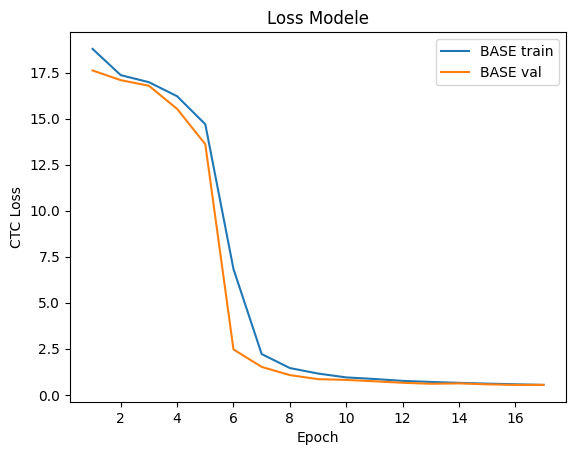

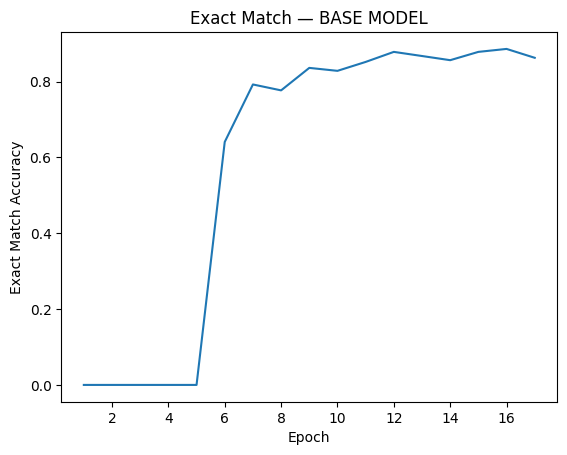

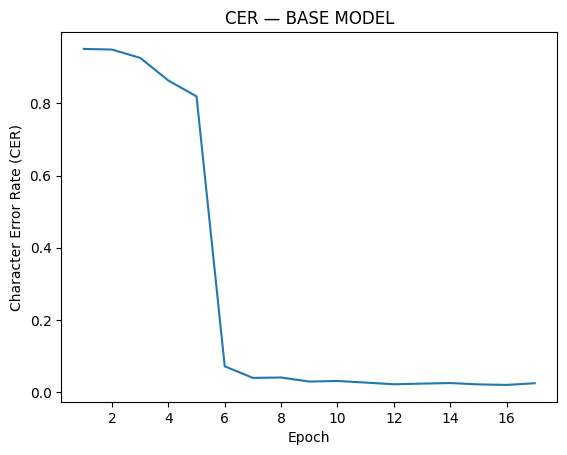

In [2]:
# =========================================================
# COMPARE OCR TRAINING — BASE vs FINETUNE (ROBUST JSON)
# =========================================================
import json
import matplotlib.pyplot as plt

# =========================================================
# LOAD JSON FILES
# =========================================================
with open("log_model_9b.json", "r") as f:
    base_log = json.load(f)

with open("log_fintune.json", "r") as f:
    ft_log = json.load(f)

# =========================================================
# BASE MODEL HISTORY
# =========================================================
base_hist = base_log["training"]["history"]

base_epochs    = [h["epoch"] for h in base_hist]
base_loss      = [h["loss"] for h in base_hist]
base_val_loss  = [h["val_loss"] for h in base_hist]
base_cer       = [h["cer"] for h in base_hist]
base_exact     = [h["exact_match"] for h in base_hist]

# =========================================================
# FINETUNE HISTORY (PHASE A + PHASE B)
# =========================================================
phaseA = ft_log["phase_A"]["history"]
phaseB = ft_log["phase_B"]["history"]

ft_epochs = []
ft_loss = []
ft_val_loss = []

epoch_counter = 1

for h in phaseA:
    ft_epochs.append(epoch_counter)
    ft_loss.append(h["loss"])
    ft_val_loss.append(h["val_loss"])
    epoch_counter += 1

for h in phaseB:
    ft_epochs.append(epoch_counter)
    ft_loss.append(h["loss"])
    ft_val_loss.append(h["val_loss"])
    epoch_counter += 1

# =========================================================
# 1) LOSS COMPARISON
# =========================================================
plt.figure()
plt.plot(base_epochs, base_loss, label="BASE train")
plt.plot(base_epochs, base_val_loss, label="BASE val")
# plt.plot(ft_epochs, ft_loss, linestyle="--", label="FINETUNE train")
# plt.plot(ft_epochs, ft_val_loss, linestyle="--", label="FINETUNE val")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Loss Modele")
plt.legend()
plt.show()

# =========================================================
# 2) EXACT MATCH (BASE ONLY)
# =========================================================
plt.figure()
plt.plot(base_epochs, base_exact)
plt.xlabel("Epoch")
plt.ylabel("Exact Match Accuracy")
plt.title("Exact Match — BASE MODEL")
plt.show()

# =========================================================
# 3) CER (BASE ONLY)
# =========================================================
plt.figure()
plt.plot(base_epochs, base_cer)
plt.xlabel("Epoch")
plt.ylabel("Character Error Rate (CER)")
plt.title("CER — BASE MODEL")
plt.show()


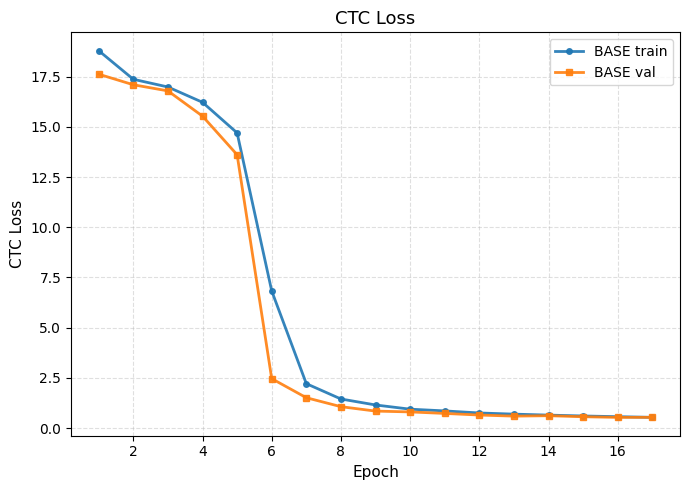

In [4]:
plt.figure(figsize=(7, 5))

plt.plot(
    base_epochs,
    base_loss,
    label="BASE train",
    linewidth=2,
    marker="o",
    markersize=4,
    alpha=0.9
)

plt.plot(
    base_epochs,
    base_val_loss,
    label="BASE val",
    linewidth=2,
    marker="s",
    markersize=4,
    alpha=0.9
)

plt.xlabel("Epoch", fontsize=11)
plt.ylabel("CTC Loss", fontsize=11)
plt.title("CTC Loss", fontsize=13)

plt.legend(frameon=True)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
